In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from swmm_api import read_out_file
import os
from matplotlib.gridspec import GridSpec

from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['Arial'],#['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

In [43]:
train_rewards = {}
train_rewards['PPO']=np.load('./step3-LFS/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-1']=np.load('./step3-LFS - multitrain/Results_PPO_reward3/Results/1_Train.npy',allow_pickle=True).tolist()['Episode_reward']
#train_rewards['PPO-2']=np.load('./step3-LFS - multitrain/Results_PPO_reward3/Results/2_Train.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-2']=np.load('./step3-LFS - multitrain/Results_PPO_reward3/Results/3_Train.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-3']=np.load('./step3-LFS - multitrain/Results_PPO_reward3/Results/4_Train.npy',allow_pickle=True).tolist()['Episode_reward']

train_rewards['PPO-KGK1-1']=np.load('./step2-finetuneK1 - multitrain/Results_PPO_reward3/Results/1_Train200.npy',allow_pickle=True).tolist()['Episode_reward'][10:]
train_rewards['PPO-KGK1-2']=np.load('./step2-finetuneK1 - multitrain/Results_PPO_reward3/Results/2_Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK1-3']=np.load('./step2-finetuneK1 - multitrain/Results_PPO_reward3/Results/3_Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK1']=np.load('./step2-finetuneK1/Results_PPO_reward3/Results/Train200.npy',allow_pickle=True).tolist()['Episode_reward']

train_rewards['PPO-KGK2-1']=np.load('./step2-finetuneK2 - multitrain/Results_PPO_reward3/Results/1_Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK2-2']=np.load('./step2-finetuneK2 - multitrain/Results_PPO_reward3/Results/2_Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK2-3']=np.load('./step2-finetuneK2 - multitrain/Results_PPO_reward3/Results/3_Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK2']=np.load('./step2-finetuneK2/Results_PPO_reward3/Results/Train400.npy',allow_pickle=True).tolist()['Episode_reward']

train_rewards['PPO-KGK3-1']=np.load('./step2-finetuneK3 - multitrain/Results_PPO_reward3/Results/1_Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK3-2']=np.load('./step2-finetuneK3 - multitrain/Results_PPO_reward3/Results/2_Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK3-3']=np.load('./step2-finetuneK3 - multitrain/Results_PPO_reward3/Results/3_Train200.npy',allow_pickle=True).tolist()['Episode_reward']
train_rewards['PPO-KGK3']=np.load('./step2-finetuneK3/Results_PPO_reward3/Results/Train100.npy',allow_pickle=True).tolist()['Episode_reward']

train_rewards['PPO-KGK123-1']=np.load('./step2-finetuneK123 - multitrain/Results_PPO_reward3/Results/1_Train150.npy',allow_pickle=True).tolist()['Episode_reward'][:90]
train_rewards['PPO-KGK123-2']=np.load('./step2-finetuneK123 - multitrain/Results_PPO_reward3/Results/2_Train150.npy',allow_pickle=True).tolist()['Episode_reward'][:90]
train_rewards['PPO-KGK123-3']=np.load('./step2-finetuneK123 - multitrain/Results_PPO_reward3/Results/3_Train200.npy',allow_pickle=True).tolist()['Episode_reward'][:90]
train_rewards['PPO-KGK123']=np.load('./step2-finetuneK123/Results_PPO_reward3/Results/Train200.npy',allow_pickle=True).tolist()['Episode_reward'][:90]

train_rewards['PPO-preK1']=np.load('./step1-pretrainK1/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
train_rewards['PPO-preK2']=np.load('./step1-pretrainK2/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
train_rewards['PPO-preK3']=np.load('./step1-pretrainK3/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()
train_rewards['PPO-preK123']=np.load('./step1-pretrainK123/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()

#train_rewards['DQN nosafe']=np.load('./step3-DRL fullnosafe/Results_DQN_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']
#train_rewards['PPO nosafe']=np.load('./step3-DRL fullnosafe/Results_PPO_reward3/Results/Train.npy',allow_pickle=True).tolist()['Episode_reward']

# 画多次训练的范围图

In [44]:
def find_maxmin(id):
    train_rewards['PPO'+id+'-max'] = []
    train_rewards['PPO'+id+'-min'] = []
    n = np.min([len(train_rewards['PPO'+id+'-1']),
               len(train_rewards['PPO'+id+'-2']),
               len(train_rewards['PPO'+id+'-3']),
               len(train_rewards['PPO'+id])])
    for i in range(n):
        train_rewards['PPO'+id+'-max'].append(np.max([train_rewards['PPO'+id+'-1'][i],
                                                    train_rewards['PPO'+id+'-2'][i],
                                                    train_rewards['PPO'+id+'-3'][i],
                                                    train_rewards['PPO'+id][i]]))
        train_rewards['PPO'+id+'-min'].append(np.min([train_rewards['PPO'+id+'-1'][i],
                                                    train_rewards['PPO'+id+'-2'][i],
                                                    train_rewards['PPO'+id+'-3'][i],
                                                    train_rewards['PPO'+id][i]]))

for id in ['-KGK1','-KGK2','-KGK3','-KGK123']:
    print(id)
    find_maxmin(id)

-KGK1
-KGK2
-KGK3
-KGK123


In [45]:
train_rewards['PPO-max'] = []
train_rewards['PPO-min'] = []
n = np.min([len(train_rewards['PPO-1']),
            len(train_rewards['PPO-2']),
            len(train_rewards['PPO-3']),
            len(train_rewards['PPO'])])
for i in range(n):
    train_rewards['PPO-max'].append(np.max([train_rewards['PPO-1'][i],
                                            train_rewards['PPO'][i]]))
    train_rewards['PPO-min'].append(np.min([train_rewards['PPO-1'][i],
                                                train_rewards['PPO-2'][i],
                                                train_rewards['PPO-3'][i],
                                                train_rewards['PPO'][i]]))

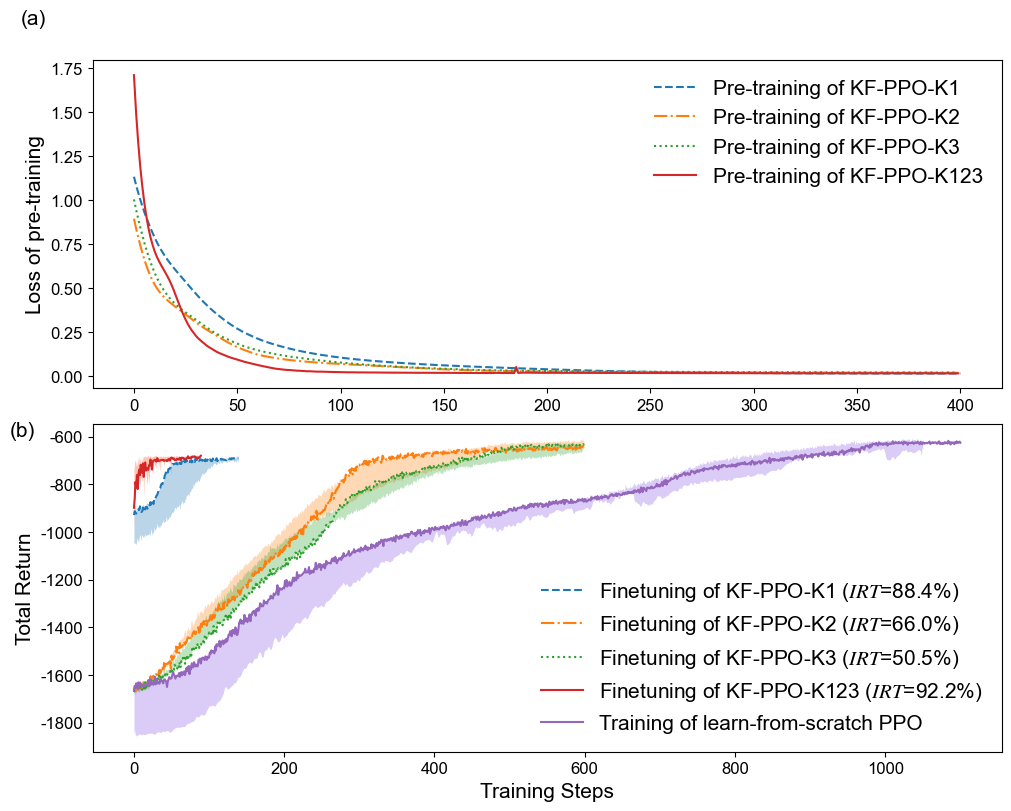

In [46]:
fig = plt.figure(dpi=100,
                 constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
                 figsize=(10,8)
                )
gs = GridSpec(2, 1, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

ccf = {'BC':'#7f7f7f',
       'PPO':'#8756e4',
       'K1':'#1f77b4',
       'K2':'#ff7f0e',
       'K3':'#2ca02c',
       'K123':'#fd3c06'
       }

ax4 = fig.add_subplot(gs[0])
ax4.plot(np.array(train_rewards['PPO-preK1']['Loss'][10:411])/50,linestyle='--',label='Pre-training of KF-PPO-K1')
#y1, y2 = train_rewards['PPO-preK1-min'], train_rewards['PPO-preK1-max']
#X = [x for x in range(len(train_rewards['PPO-preK1-min']))]
#ax4.fill_between(X,y1, y2, color=ccf['K1'], alpha=0.3)

ax4.plot(np.array(train_rewards['PPO-preK2']['Loss'][:400])/50,linestyle='-.',label='Pre-training of KF-PPO-K2')
#y1, y2 = train_rewards['PPO-preK2-min'], train_rewards['PPO-preK2-max']
#X = [x for x in range(len(train_rewards['PPO-preK2-min']))]
#ax4.fill_between(X, y1, y2, color=ccf['K2'], alpha=0.3)

ax4.plot(np.array(train_rewards['PPO-preK3']['Loss'][:400])/50,linestyle=':',label='Pre-training of KF-PPO-K3')
#y1, y2 = train_rewards['PPO-preK3-min'], train_rewards['PPO-preK3-max']
#X = [x for x in range(len(train_rewards['PPO-preK1-min']))]
#ax4.fill_between(X, y1, y2, color=ccf['K3'], alpha=0.3)

ax4.plot(np.array(train_rewards['PPO-preK123']['Loss'][::3][:400])/50,label='Pre-training of KF-PPO-K123') #3组数据，每组迭代5次training，所以每隔15次选一个数；与其他pretrain保持一致，每3组选一个
#y1, y2 = train_rewards['PPO-preK123-min'], train_rewards['PPO-preK123-max']
#X = [x for x in range(len(train_rewards['PPO-preK123-min']))]
#ax4.fill_between(X, y1, y2, color=ccf['K123'], alpha=0.3)

#ax4.plot(train_rewards['PPO-preK4']['Loss'][:300],label='Pre-training of KF-PPO-K4')
ax4.legend(fontsize=15,frameon=False)
ax4.set_ylabel('Loss of pre-training',fontsize=15)
plt.text(x=-55,y=2.0, s='(a)',fontsize=15)

##################################################################################################

ax2 = fig.add_subplot(gs[1])
ax2.plot(train_rewards['PPO-KGK1'][:140],linestyle='--',label='Finetuning of KF-PPO-K1 ('+r'${IRT}$'+'=88.4%)')
y1, y2 = train_rewards['PPO-KGK1-min'][:140], train_rewards['PPO-KGK1-max'][:140]
X = [x for x in range(len(train_rewards['PPO-KGK1-min'][:140]))]
ax2.fill_between(X,y1, y2, color=ccf['K1'], alpha=0.3, linewidth=0)

ax2.plot(train_rewards['PPO-KGK2'][:600],linestyle='-.',label='Finetuning of KF-PPO-K2 ('+r'${IRT}$'+'=66.0%)')
y1, y2 = train_rewards['PPO-KGK2-min'][:600], train_rewards['PPO-KGK2-max'][:600]
X = [x for x in range(len(train_rewards['PPO-KGK2-min'][:600]))]
ax2.fill_between(X,y1, y2, color=ccf['K2'], alpha=0.3, linewidth=0)

ax2.plot(train_rewards['PPO-KGK3'][:600],linestyle=':',label='Finetuning of KF-PPO-K3 ('+r'${IRT}$'+'=50.5%)')
y1, y2 = train_rewards['PPO-KGK3-min'][:600], train_rewards['PPO-KGK3-max'][:600]
X = [x for x in range(len(train_rewards['PPO-KGK3-min'][:600]))]
ax2.fill_between(X,y1, y2, color=ccf['K3'], alpha=0.3, linewidth=0)

ax2.plot(train_rewards['PPO-KGK123'][:100],label='Finetuning of KF-PPO-K123 ('+r'${IRT}$'+'=92.2%)')
y1, y2 = train_rewards['PPO-KGK123-min'][:], train_rewards['PPO-KGK123-max'][:]
X = [x for x in range(len(train_rewards['PPO-KGK123-min'][:]))]
ax2.fill_between(X,y1, y2, color=ccf['K123'], alpha=0.3, linewidth=0)

ax2.plot(train_rewards['PPO'][:],label='Training of learn-from-scratch PPO')
y1, y2 = train_rewards['PPO-min'][:], train_rewards['PPO-max'][:]
X = [x for x in range(len(train_rewards['PPO-min'][:]))]
ax2.fill_between(X,y1, y2, color=ccf['PPO'], alpha=0.3, linewidth=0)

ax2.legend(fontsize=15,frameon=False)
ax2.set_ylabel('Total Return',fontsize=15)
ax2.set_xlabel('Training Steps',fontsize=15)
#ax2.set_xlabel('Training Epoch',fontsize=20)s
plt.text(x=-165,y=-600, s='(b)',fontsize=15)

plt.savefig('./PPO_train.png',dpi=200,bbox_inches='tight')

# Time
## finetune收敛步数：K1：120；K2：390；K3：580；K123：100
## 选择的pretrained model：K1：200，K2：200，K3：200，K123：200; 每10步记录一次时间，所以下面时间数据的编号除以10

In [47]:
# 每10步记录一次时间
times = {}
#times['DQN'] = np.load('./step3-DRL full/Results_DQN_reward3/time.npy',allow_pickle=True).tolist()
times['PPO'] = np.load('./step3-LFS/Results_PPO_reward3/time.npy',allow_pickle=True).tolist()
#times['Pre-DQN'] = np.load('./step1-DRL pretrain/Results_DQN_reward3/time.npy',allow_pickle=True).tolist()
times['Pre-PPO-K1'] = np.load('./step1-pretrainK1/Results_PPO_reward3/time.npy',allow_pickle=True).tolist()
times['Pre-PPO-K2'] = np.load('./step1-pretrainK2/Results_PPO_reward3/time.npy',allow_pickle=True).tolist()
times['Pre-PPO-K3'] = np.load('./step1-pretrainK3/Results_PPO_reward3/time.npy',allow_pickle=True).tolist()
times['Pre-PPO-K123'] = np.load('./step1-pretrainK123/Results_PPO_reward3/time.npy',allow_pickle=True).tolist()
#times['Pre-PPO-K4'] = np.load('./step1-pretrainK4/Results_PPO_reward3/time.npy',allow_pickle=True).tolist()
times['KG-PPO-K1'] = np.load('./step2-finetuneK1/Results_PPO_reward3/time200.npy',allow_pickle=True).tolist()
times['KG-PPO-K2'] = np.load('./step2-finetuneK2/Results_PPO_reward3/time200.npy',allow_pickle=True).tolist()
times['KG-PPO-K3'] = np.load('./step2-finetuneK3/Results_PPO_reward3/time200.npy',allow_pickle=True).tolist()
times['KG-PPO-K123'] = np.load('./step2-finetuneK123/Results_PPO_reward3/time200.npy',allow_pickle=True).tolist()
#times['KG-PPO-K4'] = np.load('./step2-finetuneK4/Results_PPO_reward3/time100.npy',allow_pickle=True).tolist()
#times['Pre-DQN-OPT'] = np.load('./step1-DRL pretrainOPT/Results_DQN_reward3/time.npy',allow_pickle=True).tolist()

In [48]:
LFS,K1,K2,K3,K123 = 110,12,39,58,int(90/10)
print(
    {
        'PPO':times['PPO'][LFS]}
        )
print(
    {
        'KF-PPO-K1':times['KG-PPO-K1'][K1],
        'KF-PPO-K2':times['KG-PPO-K2'][K2],
        'KF-PPO-K3':times['KG-PPO-K3'][K3],
        'KF-PPO-K123':times['KG-PPO-K123'][K123],}
)
print(
    {
        'Pre-PPO-K1':times['Pre-PPO-K1'][20],
        'Pre-PPO-K2':times['Pre-PPO-K2'][20],
        'Pre-PPO-K3':times['Pre-PPO-K3'][20],
        'Pre-PPO-K123':times['Pre-PPO-K123'][15]
    }
)
print(times['KG-PPO-K1'][K1]+times['Pre-PPO-K1'][20],
      times['KG-PPO-K2'][K2]+times['Pre-PPO-K2'][20],
      times['KG-PPO-K3'][K3]+times['Pre-PPO-K3'][20],
      times['KG-PPO-K123'][K123]+times['Pre-PPO-K123'][15])

{'PPO': 15209.171149599999}
{'KF-PPO-K1': 1837.5092574, 'KF-PPO-K2': 5526.6260969, 'KF-PPO-K3': 7527.7007966, 'KF-PPO-K123': 1334.072369}
{'Pre-PPO-K1': 1980.103028, 'Pre-PPO-K2': 1835.7573904, 'Pre-PPO-K3': 1839.9326913, 'Pre-PPO-K123': 4461.020911}
3817.6122854 7362.3834873000005 9367.6334879 5795.093279999999


In [49]:
irf_k1 = (times['PPO'][LFS]-times['KG-PPO-K1'][K1])/times['PPO'][LFS]
irf_k2 = (times['PPO'][LFS]-times['KG-PPO-K2'][K2])/times['PPO'][LFS]
irf_k3 = (times['PPO'][LFS]-times['KG-PPO-K3'][K3])/times['PPO'][LFS]
irf_k123 = (times['PPO'][LFS]-times['KG-PPO-K123'][K123])/times['PPO'][LFS]
print(irf_k1,irf_k2,irf_k3,irf_k123)

0.8791841291464244 0.6366254253739955 0.5050551589855717 0.9122850051539406
